In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from collections import defaultdict
import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [5]:
# df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results_info.yaml")) as results_info_file:
#     results_info = yaml.safe_load(results_info_file)

df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
    results_real_info = yaml.safe_load(results_real_info_file)
df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]

df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
    results_gen_info = yaml.safe_load(results_gen_info_file)

df = df_gen.append(df_real, sort=True)

df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
#     'collisionless_localization_update_absolute_translation_error_mean': 'collisionless_absolute_translation_error',
#     'collisionless_localization_update_absolute_rotation_error_mean': 'collisionless_absolute_rotation_error',
#     'collisionless_localization_update_normalized_relative_translation_error_mean': 'collisionless_normalized_relative_translation_error',
#     'collisionless_localization_update_normalized_relative_rotation_error_mean': 'collisionless_normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

results_info = results_gen_info
results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# TEMP: only consider real localization
df = df[df.localization_node != 'localization_generator']
# df = df[(df.amcl_alpha_factor == 1.0) | (df.amcl_alpha_factor == 0.0)]

df.fixed_rpp = df.fixed_rpp.fillna(False)
df.loc[(df.fixed_rpp == False) & (df.local_planner_node == 'rpp'), 'local_planner_node'] = 'rpp_bad'
df = df[df.local_planner_node != 'rpp_bad'].copy()

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['collisionless_success_rate'] = df['success_rate'] & (1 - df['collision_rate'])
metrics += ['average_velocity', 'collisionless_success_rate']
metrics_and_versions += ['average_velocity', 'collisionless_success_rate']

# add aggregated data
min_trajectory_length_group_df = df.groupby(["environment_name", "run_index", "collisionless_success_rate"])
for (environment_name, run_index, collisionless_success_rate), group_df in min_trajectory_length_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (collisionless_success_rate), 'min_trajectory_length'] = group_df.trajectory_length.min()
df['norm_trajectory_length'] = df.trajectory_length / df.min_trajectory_length
metrics += ['norm_trajectory_length']
metrics_and_versions += ['norm_trajectory_length']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "collisionless_success_rate"])
for (environment_name, run_index, collisionless_success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (collisionless_success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

# if True:
if False:
    printmd("## Number of Runs")
    printmd(f"    {len(df.run_id.unique())}")

    printmd("## Run Parameters")
    for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
        values = list(df[name].unique())
        printmd(f"    {name:<70}", sorted(values))

    printmd("## Metrics")
    for name in metrics_and_versions:
        if name in metrics_versions:
            if len(df[name].unique()) == 1:
                printmd(f"    {name:<70} {sorted(df[name].unique())}")
            else:
                printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
        else:
            printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

In [6]:
def plot_model_and_data(output_metric, primary_feature, secondary_feature, min_bin_count, selected_df, min_y=0.0, max_y=1.0):
    primary_feature_d = f'{primary_feature}_d'
    secondary_feature_d = f'{secondary_feature}_d'
    n = 10
    
    fig = plt.figure()
    for localization_node in df.localization_node.unique():
        for secondary_feature_d_value in selected_df[secondary_feature_d].unique():
            df_l = selected_df[
                (selected_df.localization_node == localization_node) & 
                (selected_df[secondary_feature_d] == secondary_feature_d_value) & 
                selected_df[primary_feature_d].notna() & 
                selected_df[output_metric].notna()
            ].copy()

            primary_feature_ls = np.linspace(df_l[primary_feature].min(), df_l[primary_feature].max(), n)
            primary_feature_transformed_ls = localization_feature_transforms[primary_feature](primary_feature_ls)
            secondary_feature_ls = np.array([secondary_feature_d_value]*n)
            secondary_feature_transformed_ls = localization_feature_transforms[secondary_feature](secondary_feature_ls)

            X = np.array([primary_feature_ls, secondary_feature_ls]).T
            X_t = np.array([primary_feature_transformed_ls, secondary_feature_transformed_ls]).T
            y_predict = model_localization[localization_node][output_metric].predict(X_t)
            plt.plot(primary_feature_ls, y_predict, '.-', label=f"{localization_node.replace('_', ' ')}, {secondary_feature.replace('_', ' ')}={secondary_feature_d_value}, pred")
            
            if len(df_l[primary_feature_d]):
                df_g = df_l.groupby(primary_feature_d).agg(['mean', 'count'])
                df_g = df_g[ df_g[(output_metric, 'count')] > min_bin_count ]
                plt.plot(df_g.index, df_g[(output_metric, 'mean')], 'o--', label=f"{localization_node.replace('_', ' ')}, {secondary_feature.replace('_', ' ')}={secondary_feature_d_value}, data")

    plt.grid()
    plt.legend()
    plt.xlabel(primary_feature.replace('_', ' '))
    plt.ylabel(output_metric.replace('_', ' '))
    plt.ylim([min_y, max_y])
    fig.set_size_inches([6, 6])
    plt.show()

def plot_model_and_data_local_planner(output_metric, primary_feature, secondary_feature, min_bin_count, selected_df, local_planner_nodes=None, min_y=0.0, max_y=1.0):
    primary_feature_d = f'{primary_feature}_d' 
    secondary_feature_d = f'{secondary_feature}_d'
    n = 100
    
    fig = plt.figure()
    if local_planner_nodes is None:
        local_planner_nodes = df.local_planner_node.unique()
    for local_planner_node in local_planner_nodes:
        for secondary_feature_d_value in selected_df[secondary_feature_d].unique():
            df_l = selected_df[
                (selected_df.local_planner_node == local_planner_node) & 
                (selected_df[secondary_feature_d] == secondary_feature_d_value) & 
                selected_df[primary_feature_d].notna() & 
                selected_df[output_metric].notna()
            ].copy()
            if not len(df_l):
                continue

            primary_feature_ls = np.linspace(df_l[primary_feature].min(), df_l[primary_feature].max(), n)
            primary_feature_transformed_ls = local_planner_feature_transforms[primary_feature](primary_feature_ls)
            secondary_feature_ls = np.array([secondary_feature_d_value]*n)
            secondary_feature_transformed_ls = local_planner_feature_transforms[secondary_feature](secondary_feature_ls)

            X = np.array([primary_feature_ls, secondary_feature_ls]).T
            X_t = np.array([primary_feature_transformed_ls, secondary_feature_transformed_ls]).T
            y_predict = model_local_planner[local_planner_node][output_metric].predict(X_t)
            plt.plot(primary_feature_ls, y_predict, label=f"{local_planner_node.replace('_', ' ')}, {secondary_feature.replace('_', ' ')}={secondary_feature_d_value}, pred")
            
            if len(df_l[primary_feature_d]):
                df_g = df_l.groupby(primary_feature_d).agg(['mean', 'count'])
                df_g = df_g[ df_g[(output_metric, 'count')] > min_bin_count ]
                plt.plot(df_g.index, df_g[(output_metric, 'mean')], 'o-', label=f"{local_planner_node.replace('_', ' ')}, {secondary_feature.replace('_', ' ')}={secondary_feature_d_value}, data")

    plt.grid()
    plt.legend()
    plt.xlabel(primary_feature.replace('_', ' '))
    plt.ylabel(output_metric.replace('_', ' '))
    plt.ylim([min_y, max_y])
    fig.set_size_inches([10, 10])
    plt.show()

In [7]:
# discretize features

bin_widths_dict = {'average_translation_velocity': 0.02, 'absolute_translation_error': 0.05, 'absolute_rotation_error': 0.01, 'normalized_relative_translation_error': 0.03, 'normalized_relative_rotation_error': 0.01, 'beta_1': None}

discrete_feature_names = list()
for feature_name, bin_width in bin_widths_dict.items():
    discrete_feature_names.append(f'{feature_name}_d')
    if bin_width is not None:
        bins = np.arange(0., df[feature_name].max(), bin_width)
        df[f'{feature_name}_d'] = pd.cut(df[feature_name], bins, labels=bins[:-1]).astype('float')
    else:
        df[f'{feature_name}_d'] = df[feature_name]

      amcl               absolute_translation_error | +0.6460

      amcl                  absolute_rotation_error | +0.2879

      amcl    normalized_relative_translation_error | +0.5289

      amcl       normalized_relative_rotation_error | +0.0280

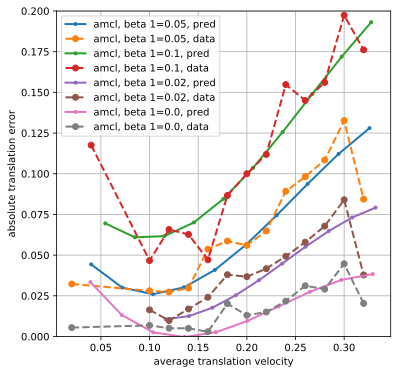

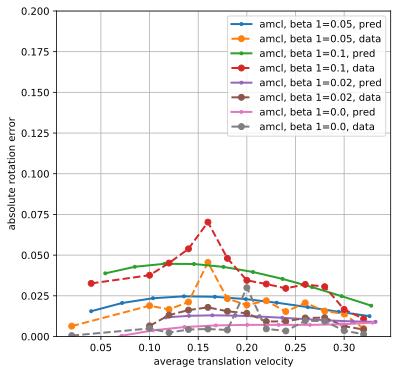

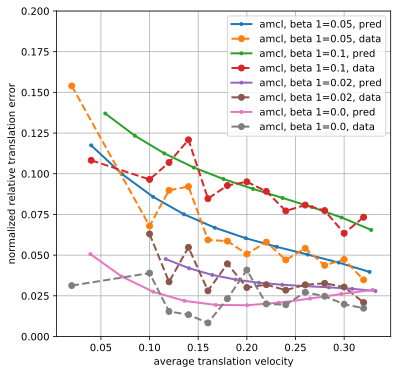

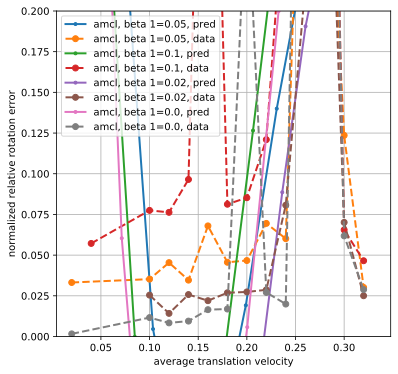

In [8]:
df_localization = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & ((df.amcl_alpha_factor == 1.0) | (df.amcl_alpha_factor == 0.0))].copy()

localization_feature_transforms = {
    'average_translation_velocity': lambda x: x,
    'beta_1': lambda x: x,
}
localization_output_metrics = ['absolute_translation_error', 'absolute_rotation_error', 'normalized_relative_translation_error', 'normalized_relative_rotation_error']
df_localization = df_localization[['localization_node', 'local_planner_node'] + list(localization_feature_transforms.keys()) + discrete_feature_names + localization_output_metrics].copy()
df_localization.dropna(inplace=True)

localization_transformed_feature_names = list()
for feature_name, feature_transform in localization_feature_transforms.items():
    df_localization[f'{feature_name}_tf'] = feature_transform(df_localization[feature_name])
    localization_transformed_feature_names.append(f'{feature_name}_tf')

num_polynomial_features = 3

model_localization = defaultdict(dict)

for localization_node in df.localization_node.unique():
    for output_metric in localization_output_metrics:
        df_l = df_localization[df_localization.localization_node == localization_node]
        X_all = df_l[localization_transformed_feature_names].values
        y_all = df_l[output_metric].values

        model_localization[localization_node][output_metric] = make_pipeline(PolynomialFeatures(num_polynomial_features, interaction_only=False), LinearRegression())
        model_localization[localization_node][output_metric].fit(X_all, y_all);

        y_pred_all = model_localization[localization_node][output_metric].predict(X_all)
        r2_all = r2_score(y_all, y_pred_all)

        printmd(f"{localization_node:>10} {output_metric:>40} | {r2_all:+0.4f}")

for output_metric in localization_output_metrics:
    plot_model_and_data(output_metric=output_metric, primary_feature='average_translation_velocity',  secondary_feature='beta_1', min_bin_count=0, selected_df=df_localization, min_y=0.0, max_y=0.2)

       teb                   norm_trajectory_length | +0.4110

       dwb                   norm_trajectory_length | +0.3930

       rpp                   norm_trajectory_length | +0.3129

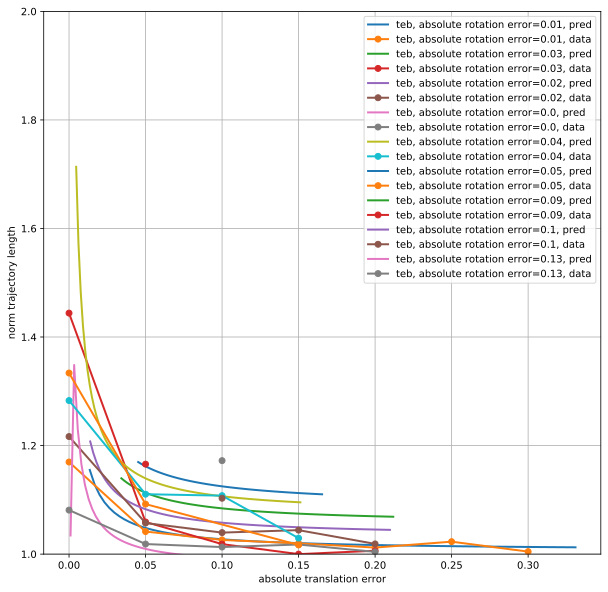

In [9]:
df_local_planner = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & ((df.amcl_alpha_factor == 1.0) | (df.amcl_alpha_factor == 0.0))].copy()

local_planner_feature_transforms = {
    'absolute_translation_error': lambda x: 1/x,
    'absolute_rotation_error': lambda x: x,
}
local_planner_output_metrics = ['norm_trajectory_length']

df_local_planner = df_local_planner[['localization_node', 'local_planner_node'] + list(local_planner_feature_transforms.keys()) + discrete_feature_names + local_planner_output_metrics].copy()
df_local_planner.dropna(inplace=True)

local_planner_transformed_feature_names = list()
for feature_name, feature_transform in local_planner_feature_transforms.items():
    df_local_planner[f'{feature_name}_tf'] = feature_transform(df_local_planner[feature_name])
    local_planner_transformed_feature_names.append(f'{feature_name}_tf')

output_metric = local_planner_output_metrics[0]
num_polynomial_features = 2

model_local_planner = defaultdict(dict)

for local_planner_node in df.local_planner_node.unique():
    df_l = df_local_planner[df_local_planner.local_planner_node == local_planner_node]
    X_all = df_l[local_planner_transformed_feature_names].values
    y_all = df_l[output_metric].values

    model_local_planner[local_planner_node][output_metric] = make_pipeline(PolynomialFeatures(num_polynomial_features, interaction_only=False), LinearRegression())
    model_local_planner[local_planner_node][output_metric].fit(X_all, y_all);

    y_pred_all = model_local_planner[local_planner_node][output_metric].predict(X_all)
    r2_all = r2_score(y_all, y_pred_all)

    printmd(f"{local_planner_node:>10} {output_metric:>40} | {r2_all:+0.4f}")

for output_metric in local_planner_output_metrics:
    plot_model_and_data_local_planner(output_metric='norm_trajectory_length', primary_feature='absolute_translation_error',  secondary_feature='absolute_rotation_error', min_bin_count=0, selected_df=df_local_planner, local_planner_nodes=['teb'], min_y=1.0, max_y=2.0)

### absolute_translation_error vs collisionless_absolute_translation_error (TEB)

sn: 312    sc: 0    fn: 26    fc: 25    


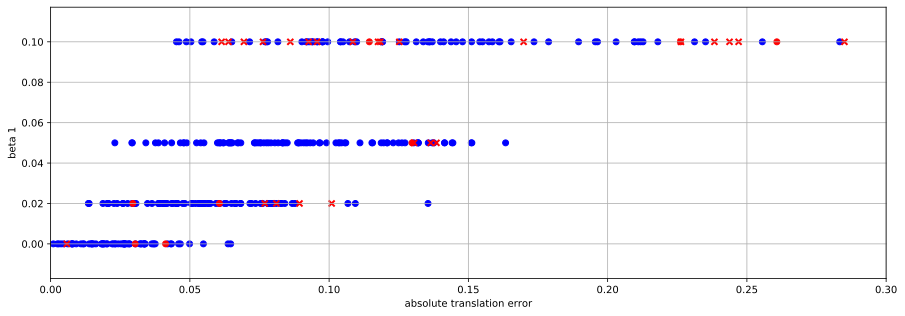

### absolute_rotation_error vs collisionless_absolute_rotation_error (TEB)

sn: 312    sc: 0    fn: 26    fc: 25    


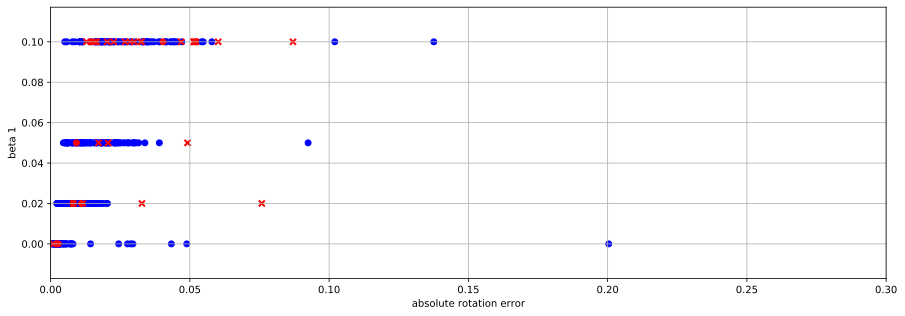

### normalized_relative_translation_error vs collisionless_normalized_relative_translation_error (TEB)

sn: 312    sc: 0    fn: 26    fc: 25    


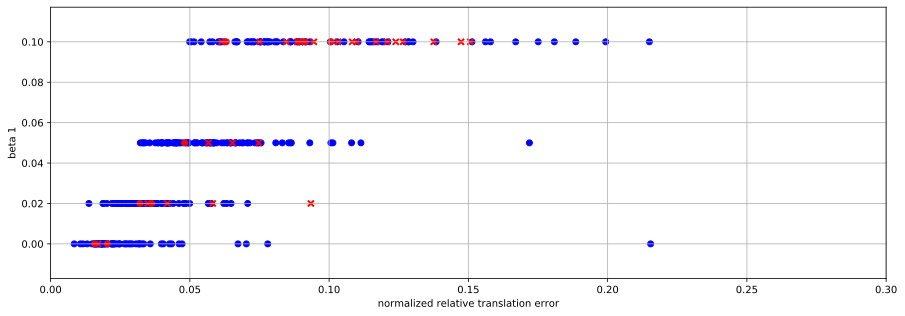

### normalized_relative_rotation_error vs collisionless_normalized_relative_rotation_error (TEB)

sn: 312    sc: 0    fn: 26    fc: 25    


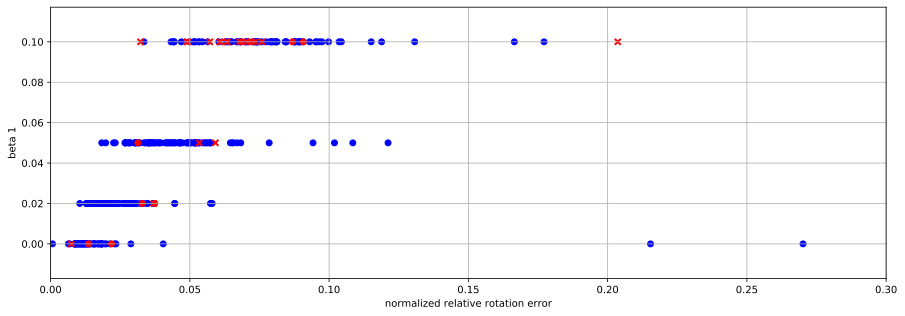

In [10]:
def scatter_xy_datapoints_by_success_and_collision_rate(df_plot, x_name, y_name, x_range):
    plt.figure().set_size_inches([15, 5])
    sn = df_plot[(df_plot.collisionless_success_rate == 1) & (df_plot.collision_rate == 0)]
    sc = df_plot[(df_plot.collisionless_success_rate == 1) & (df_plot.collision_rate == 1)]
    fn = df_plot[(df_plot.collisionless_success_rate == 0) & (df_plot.collision_rate == 0)]
    fc = df_plot[(df_plot.collisionless_success_rate == 0) & (df_plot.collision_rate == 1)]
    print(f"sn: {len(sn)}    sc: {len(sc)}    fn: {len(fn)}    fc: {len(fc)}    ")
    plt.scatter(sn[x_name], sn[y_name], marker='o', color='blue')
    plt.scatter(fn[x_name], fn[y_name], marker='o', color='red')
    plt.scatter(sc[x_name], sc[y_name], marker='x', color='blue')
    plt.scatter(fc[x_name], fc[y_name], marker='x', color='red')
    plt.xlabel(x_name.replace('_', ' '))
    plt.ylabel(y_name.replace('_', ' '))
    plt.xlim(x_range)
    plt.grid()
    plt.show()

df_plot = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.local_planner_node == 'teb') & ((df.amcl_alpha_factor == 1.0) | (df.amcl_alpha_factor == 0.0))].copy()
printmd("### absolute_translation_error vs collisionless_absolute_translation_error (TEB)")
scatter_xy_datapoints_by_success_and_collision_rate(df_plot=df_plot, x_name='absolute_translation_error', y_name='beta_1', x_range=[0, 0.3])

printmd("### absolute_rotation_error vs collisionless_absolute_rotation_error (TEB)")
scatter_xy_datapoints_by_success_and_collision_rate(df_plot=df_plot, x_name='absolute_rotation_error', y_name='beta_1', x_range=[0, 0.3])

printmd("### normalized_relative_translation_error vs collisionless_normalized_relative_translation_error (TEB)")
scatter_xy_datapoints_by_success_and_collision_rate(df_plot=df_plot, x_name='normalized_relative_translation_error', y_name='beta_1', x_range=[0, 0.3])

printmd("### normalized_relative_rotation_error vs collisionless_normalized_relative_rotation_error (TEB)")
scatter_xy_datapoints_by_success_and_collision_rate(df_plot=df_plot, x_name='normalized_relative_rotation_error', y_name='beta_1', x_range=[0, 0.3])


In [11]:
def plot_in_out_metrics_bin_count_(output_metric, input_metrics, selected_df, bin_widths=None):
    fig, axes = plt.subplots(1, len(input_metrics))

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        for local_planner_node in df.local_planner_node.unique():
            for localization_node in df.localization_node.unique():
                g = localization_node == 'localization_generator'
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy().sort_values(input_metric.name)
                if bin_width is not None:
                    if len(df_lr[input_metric.name].values) < 1:
                        continue
                    bins = list(df_lr[input_metric.name].values[::bin_width])
                    bins.append(df_lr[input_metric.name].values[-1] + 1.0)
                    
                    df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                    df_lr_g = df_lr.groupby('x_range').mean()
                    axes[i].plot(df_lr_g[input_metric.name], df_lr_g[output_metric.name], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node} {localization_node}', linewidth=3 if g else 2, color=local_planner_color[local_planner_node])
#                     axes[i].plot(df_lr_g.index, df_lr_g[output_metric.name], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node} {localization_node}', linewidth=3 if g else 2, color=local_planner_color[local_planner_node])
                else:
                    df_lr_g = df_lr.groupby(input_metric.name).mean()
                    axes[i].plot(df_lr_g.index, df_lr_g[output_metric.name], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node} {localization_node}', linewidth=3 if g else 2, color=local_planner_color[local_planner_node])

        axes[i].legend()
        axes[i].grid()
        axes[i].set_xlabel(input_metric.name.replace('_', ' '))
        axes[i].set_ylabel(output_metric.name.replace('_', ' '))
        axes[i].set_ylim([0, output_metric.max()*1.1])

    fig.set_size_inches([5*len(input_metrics), 5])
    plt.show()


### normalized_relative_translation_error, only TEB, beta = 0.0

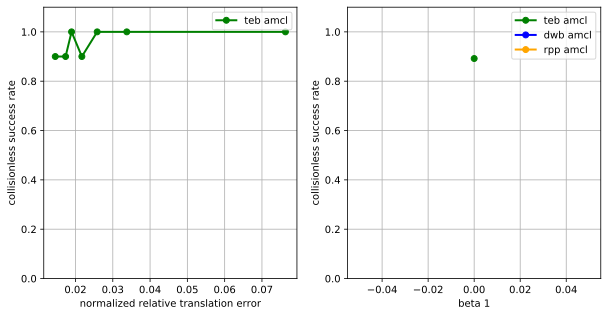

### normalized_relative_translation_error, only TEB, beta = 0.02

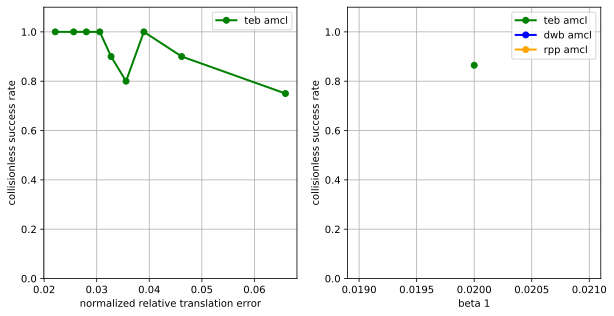

### normalized_relative_translation_error, only TEB, beta = 0.05

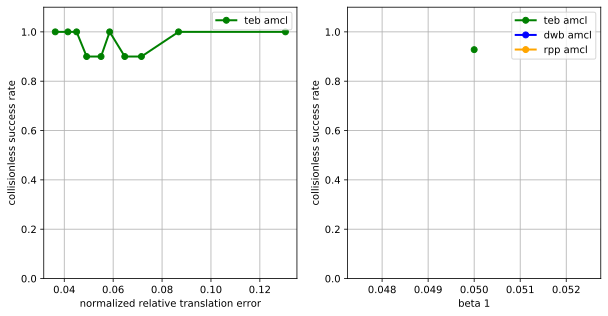

### normalized_relative_translation_error, only TEB, beta = 0.1

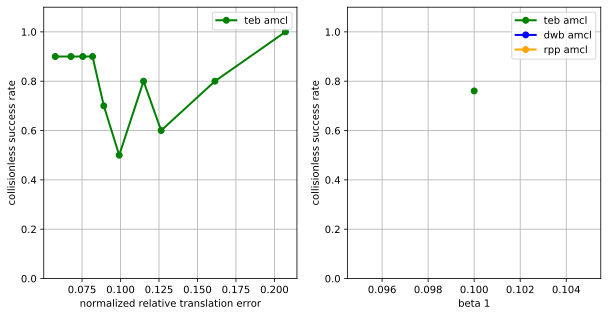

In [12]:

printmd("### normalized_relative_translation_error, only TEB, beta = 0.0")
d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.local_planner_node == 'teb') & ((df.amcl_alpha_factor == 1.0) | (df.amcl_alpha_factor == 0.0)) & (df.beta_1 == 0.00)].copy()
plot_in_out_metrics_bin_count_(output_metric=d.collisionless_success_rate, input_metrics=[d.normalized_relative_translation_error, d.beta_1], selected_df=d, bin_widths=[10, None])

printmd("### normalized_relative_translation_error, only TEB, beta = 0.02")
d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.local_planner_node == 'teb') & ((df.amcl_alpha_factor == 1.0) | (df.amcl_alpha_factor == 0.0)) & (df.beta_1 == 0.02)].copy()
plot_in_out_metrics_bin_count_(output_metric=d.collisionless_success_rate, input_metrics=[d.normalized_relative_translation_error, d.beta_1], selected_df=d, bin_widths=[10, None])

printmd("### normalized_relative_translation_error, only TEB, beta = 0.05")
d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.local_planner_node == 'teb') & ((df.amcl_alpha_factor == 1.0) | (df.amcl_alpha_factor == 0.0)) & (df.beta_1 == 0.05)].copy()
plot_in_out_metrics_bin_count_(output_metric=d.collisionless_success_rate, input_metrics=[d.normalized_relative_translation_error, d.beta_1], selected_df=d, bin_widths=[10, None])

printmd("### normalized_relative_translation_error, only TEB, beta = 0.1")
d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.local_planner_node == 'teb') & ((df.amcl_alpha_factor == 1.0) | (df.amcl_alpha_factor == 0.0)) & (df.beta_1 == 0.10)].copy()
plot_in_out_metrics_bin_count_(output_metric=d.collisionless_success_rate, input_metrics=[d.normalized_relative_translation_error, d.beta_1], selected_df=d, bin_widths=[10, None])
